In [2]:
%%capture
%cd ..

In [3]:
# Import data

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.constants import white_list
from utils import constants as cs
from scipy.integrate import simps

In [4]:
ds_root = 'dataset/cleaned'

File CSV charge creato con successo: /Users/alerong/Documents/GitHub/RUL-estimation-of-lithium-batteries/src/dataset/soh_charge/soh-CS2_33.csv
File CSV charge creato con successo: /Users/alerong/Documents/GitHub/RUL-estimation-of-lithium-batteries/src/dataset/soh_charge/soh-CS2_36.csv
File CSV charge creato con successo: /Users/alerong/Documents/GitHub/RUL-estimation-of-lithium-batteries/src/dataset/soh_charge/soh-CS2_37.csv
File CSV charge creato con successo: /Users/alerong/Documents/GitHub/RUL-estimation-of-lithium-batteries/src/dataset/soh_charge/soh-CS2_35.csv
File CSV charge creato con successo: /Users/alerong/Documents/GitHub/RUL-estimation-of-lithium-batteries/src/dataset/soh_charge/soh-CS2_34.csv
File CSV charge creato con successo: /Users/alerong/Documents/GitHub/RUL-estimation-of-lithium-batteries/src/dataset/soh_charge/soh-CS2_38.csv
Controllo e rimozione completati per soh-CS2_33.csv
Controllo e rimozione completati per soh-CS2_36.csv
Controllo e rimozione completati per s

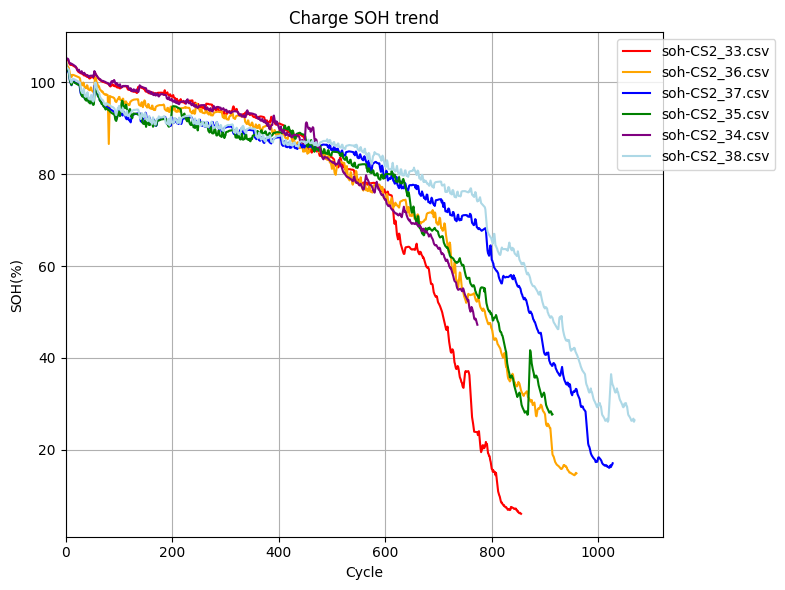

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

colors = ['red', 'orange', 'blue', 'green', 'purple', 'lightblue']

plt.figure(figsize=(8, 6))
plt_charge = plt.subplot(1, 1, 1)

soh_charge_folder = os.path.abspath(os.path.join(ds_root, '..', 'soh_charge'))
os.makedirs(soh_charge_folder, exist_ok=True)

def read_charge_file(file_path):
    df = pd.read_csv(file_path)

    first_step_index_2 = df[df['Step_Index'] == 2].groupby('Cycle_Index').head(1)
    last_step_index_4 = df[df['Step_Index'] == 4].groupby('Cycle_Index').tail(1)

    cycle_indexes2 = first_step_index_2['Cycle_Index'].index

    first = np.array([df.iloc[i, 6] for i in cycle_indexes2])
    last = np.array([df.iloc[i, 6] for i in last_step_index_4['Cycle_Index'].index])

    valid_cycles = np.where(np.abs(last - first) > 0.01)[0]
    filtered_vector = (last - first)[valid_cycles]

    cs2x_part = file_path.split('-')[1].split('.csv')[0]

    output_csv_path = os.path.join(soh_charge_folder, f'soh-{cs2x_part}.csv')
    corresponding_cycle_indexes = first_step_index_2['Cycle_Index'].iloc[valid_cycles]

    df_output = pd.DataFrame({'SOH': filtered_vector,
                              'cycle': corresponding_cycle_indexes})

    df_output.to_csv(output_csv_path, index=False)
    print(f"File CSV charge creato con successo: {output_csv_path}")

    return cs2x_part, df_output

file_names = []

for file_name in os.listdir(ds_root):
    file_path = os.path.join(ds_root, file_name)

    if file_name.startswith('charge'):
        cs2x_part, df_output = read_charge_file(file_path)

        valori_percentuali = (df_output['SOH'] / 1.1) * 100
        color = colors[len(plt_charge.lines) % len(colors)]

        plt_charge.plot(valori_percentuali, label=f'{cs2x_part}', linestyle='-', color=color)
        file_names.append(f'soh-{cs2x_part}.csv')

# Pulisci il plot prima di tracciare i nuovi dati
plt_charge.clear()

# Controllo e rimozione delle righe con valori di SOH che si discostano troppo
for file_name in file_names:
    file_path = os.path.join(soh_charge_folder, file_name)
    
    df_output = pd.read_csv(file_path)

    i = len(df_output['SOH']) - 1
    while i > 0:
        difference = abs(df_output['SOH'].iloc[i] - df_output['SOH'].iloc[i - 1])
        if difference > 0.01:
            df_output = df_output.drop(index=i)
        i -= 1

    df_output.to_csv(file_path, index=False)
    print(f"Controllo e rimozione completati per {file_name}")

    valori_percentuali = (df_output['SOH'] / 1.1) * 100
    color = colors[len(plt_charge.lines) % len(colors)]

    plt_charge.plot(valori_percentuali, label=f'{file_name}', linestyle='-', color=color)

plt_charge.set_title('Charge SOH trend')
plt_charge.set_xlabel('Cycle')
plt_charge.set_ylabel('SOH(%)')

plt.xlim(left=0)
plt_charge.grid(True)
plt_charge.legend(loc='upper right', bbox_to_anchor=(1.2, 1.))

plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Lista dei colori che vuoi utilizzare per le curve
colors = ['red', 'orange', 'blue', 'green', 'purple', 'lightblue']

# Inizializza il plot per SOH discharge
plt.figure()

# Lista per i nomi dei file SOH discharge
file_names_discharge = []

# Dizionario per memorizzare i risultati di ogni file
results_dict = {}

# Loop attraverso i file in ds_root
for i, file_name in enumerate(os.listdir(ds_root)):
    file_path = os.path.join(ds_root, file_name)
    
    if file_name.startswith('discharge'):
        df = pd.read_csv(file_path)

        first_step_index_7 = df[df['Step_Index'] == 7].groupby('Cycle_Index').head(1).index
        last_step_index_7 = df[df['Step_Index'] == 7].groupby('Cycle_Index').tail(1).index

        # Utilizza l'indice corretto (5 anziché 6)
        first1 = [df.iloc[i, 5] for i in first_step_index_7]
        last1 = [df.iloc[i, 5] for i in last_step_index_7]

        if not first1 or not last1 or len(first1) != len(last1):
            print(f"Errore: cicli non validi nel file {file_name}")
            continue

        result1 = [b - a for a, b in zip(first1, last1)]

        filtered_vector_discharge = [result1[0]]
        for i in range(1, len(result1)):
            difference = abs(result1[i] - result1[i - 1])
            if difference <= 0.01:
                filtered_vector_discharge.append(result1[i])

        cs2x_part = file_name.split('charge-')[1].split('.csv')[0]
        file_names_discharge.append(cs2x_part)

        # Salva i risultati in un file CSV nella cartella "soh_discharge"
        output_csv_path = os.path.join(soh_discharge_folder, f'soh_{cs2x_part}.csv')

        # Creazione del DataFrame
        df_soh = pd.DataFrame({'Cycle': range(1, len(filtered_vector_discharge) + 1),
                               'SOH': filtered_vector_discharge})

        # Controllo e rimozione delle righe con deviazioni eccessive
        df_soh['SOH_Diff'] = df_soh['SOH'].diff()
        threshold = 0.1  # Puoi regolare il valore di soglia a seconda della tua necessità

        # Filtraggio delle righe con deviazioni eccessive
        df_soh_filtered = df_soh[abs(df_soh['SOH_Diff']) <= threshold]

        # Eliminazione della colonna temporanea 'SOH_Diff'
        df_soh_filtered = df_soh_filtered.drop(columns=['SOH_Diff'])

        # Salvataggio del DataFrame filtrato nel file CSV
        df_soh_filtered.to_csv(output_csv_path, index=False)

        print(f"File CSV discharge creato con successo: {output_csv_path}")

        # Salva i risultati nel dizionario solo se non sono già presenti
        if cs2x_part not in results_dict:
            results_dict[cs2x_part] = df_soh_filtered['SOH'].tolist()

        # Ottieni l'indice del colore utilizzando il modulo
        color_index = len(file_names_discharge) - 1
        color = colors[color_index % len(colors)]

        # Traccia la curva utilizzando un colore dalla lista colors
        plt.plot(df_soh_filtered['SOH'], label=f'{cs2x_part}', linestyle='-', color=color)

# Aggiungi titoli e legenda
plt.title('Discharge SOH trend')
plt.xlabel('Cycle')
plt.ylabel('SOH(%)')
plt.xlim(left=0)
plt.grid(True)

# Sposta la legenda in alto a destra senza che esca dalla figura
plt.legend(file_names_discharge, loc='upper right', bbox_to_anchor=(1.2, 1.))

# Mostra il plot
plt.show()
